In [1]:
import numpy as np
import tomosipo as ts
import matplotlib.pyplot as plt
import nibabel as nib

# old code (basically when i was doing the SIRT thing!)

vg = ts.volume(
    shape=(64, 64, 64),
    size=(0.1, 0.3, 0.5),
    pos=(-0.2, 0.0, 0.0)
)

# phantom hallow!
x_true = np.ones(vg.shape, dtype=np.float32)
x_true[16:-16, 16:-16, 16:-16] = 0.0


SDD = 1.0
ROWS, COLS = 128, 192
DET_H, DET_W = 0.8, 1.0
px_v, px_u = DET_H/ROWS, DET_W/COLS

det_pos = np.array([[-SDD/2, 0.0, 0.0]])
det_v   = np.array([[0.0,  px_v, 0.0]])
det_u   = np.array([[0.0,  0.0,  px_u]])

Kx, Ky = 5, 5
dx, dy = 0.2, 0.2
x0 = -(Kx-1)*dx/2
y0 = -(Ky-1)*dy/2

# row 0 L→R, row 1 R→L,
src_pos = []
for j in range(Ky):
    xs = [x0 + i*dx for i in range(Kx)]
    if j % 2 == 1: xs = xs[::-1]
    y = y0 + j*dy
    for xx in xs:
        src_pos.append([+SDD/2, y, xx])
src_pos = np.array(src_pos)
V = len(src_pos)

det_pos_all = np.repeat(det_pos, V, axis=0)
det_v_all   = np.repeat(det_v,   V, axis=0)
det_u_all   = np.repeat(det_u,   V, axis=0)

pg = ts.cone_vec(
    shape=(ROWS, COLS),
    src_pos=src_pos,
    det_pos=det_pos_all,
    det_v=det_v_all,
    det_u=det_u_all,
)

#forward projections
A = ts.operator(vg, pg)

y = A(x_true)

projs = y

axes = np.array(projs.shape)
v_axis = int(np.where(axes == V)[0][0])
projs_v_first = np.moveaxis(projs, v_axis, 0)

In [2]:
# this is computing the world-coordinate bounding box of the volume
def volume_bbox_world(vg):
    Sz, Sy, Sx = vg.size
    pos_attr = getattr(vg, "pos", 0.0) # getting the center position of the volume
    arr = np.array(pos_attr, dtype=float).ravel() # conversion to flat NumPy array
    if arr.size >= 3: cz, cy, cx = arr[:3]
    else: cz, cy, cx = 0.0, 0.0, 0.0
    return (cz - Sz/2, cz + Sz/2, cy - Sy/2, cy + Sy/2, cx - Sx/2, cx + Sx/2)

# convert (y,x) coordinates to voxel indiced for 3d vol
def world_to_index_xy_vec(vg, y_w, x_w):
    zmin, zmax, ymin, ymax, xmin, xmax = volume_bbox_world(vg)
    Nz, Ny, Nx = vg.shape  # explicit 3D unpacking
    iy = (y_w - ymin) / (ymax - ymin) * (Ny - 1)
    ix = (x_w - xmin) / (xmax - xmin) * (Nx - 1)
    return iy, ix

# just for finding world-space z-position of your volume's slice k
def z_of_index_center(vg, k):
    zmin, zmax, _, _, _, _ = volume_bbox_world(vg)
    Nz = vg.shape[0]
    dz = (zmax - zmin) / Nz
    return zmin + (k + 0.5) * dz

# detector pixel world coords
rr, cc = np.meshgrid(np.arange(ROWS), np.arange(COLS), indexing='ij')
r0 = (ROWS - 1)/2.0
c0 = (COLS - 1)/2.0
rv = (rr - r0).astype(np.float64) #coordinnate grid for detector pixels for computed 3d world position of each detector element
cu = (cc - c0).astype(np.float64)


In [3]:
# ray -> plane (z=z_world) mapping for one view
def map_view_to_zslice(proj, i, z_world):
    proj = proj.astype(np.float32)

    S  = src_pos[i]               # (3,)
    DP = det_pos_all[i]
    DV = det_v_all[i]
    DU = det_u_all[i]

    # 3D position of each detector pixel
    P = DP[None,None,:] + rv[...,None]*DV[None,None,:] + cu[...,None]*DU[None,None,:]  # (ROWS,COLS,3)

    # Intersect source->pixel rays with plane z=z_world
    denom = P[..., 0] - S[0]                   # z-component difference
    valid = np.abs(denom) > 1e-12
    t = np.empty_like(denom)
    t[valid] = (z_world - S[0]) / denom[valid]
    valid &= (t > 0.0)
    if not np.any(valid):
        Ny, Nx = vg.shape[1], vg.shape[2]
        return np.zeros((Ny, Nx), dtype=np.float32)

    Sbc = S[None,None,:]
    R = Sbc + t[...,None] * (P - Sbc)         # (ROWS,COLS,3)
    y_w = R[...,1]; x_w = R[...,2]

    Ny, Nx = vg.shape[1], vg.shape[2]
    iy_f, ix_f = world_to_index_xy_vec(vg, y_w, x_w)
    inb = valid & (iy_f >= 0) & (iy_f <= Ny-1) & (ix_f >= 0) & (ix_f <= Nx-1)
    if not np.any(inb):
        return np.zeros((Ny, Nx), dtype=np.float32)

    # Bilinear splat to slice grid
    iyf = iy_f[inb]; ixf = ix_f[inb]
    iy0 = np.floor(iyf).astype(np.int64); iy1 = iy0 + 1
    ix0 = np.floor(ixf).astype(np.int64); ix1 = ix0 + 1
    wy = iyf - iy0; wx = ixf - ix0

    samp = proj[inb]

    out = np.zeros((Ny, Nx), dtype=np.float32)
    wgt = np.zeros((Ny, Nx), dtype=np.float32)

    w00 = (1-wy)*(1-wx); w01 = (1-wy)*wx; w10 = wy*(1-wx); w11 = wy*wx
    m00 = (iy0>=0)&(iy0<Ny)&(ix0>=0)&(ix0<Nx)
    m01 = (iy0>=0)&(iy0<Ny)&(ix1>=0)&(ix1<Nx)
    m10 = (iy1>=0)&(iy1<Ny)&(ix0>=0)&(ix0<Nx)
    m11 = (iy1>=0)&(iy1<Ny)&(ix1>=0)&(ix1<Nx)

    np.add.at(out, (iy0[m00], ix0[m00]), (samp[m00]*w00[m00]).astype(np.float32))
    np.add.at(out, (iy0[m01], ix1[m01]), (samp[m01]*w01[m01]).astype(np.float32))
    np.add.at(out, (iy1[m10], ix0[m10]), (samp[m10]*w10[m10]).astype(np.float32))
    np.add.at(out, (iy1[m11], ix1[m11]), (samp[m11]*w11[m11]).astype(np.float32))

    np.add.at(wgt, (iy0[m00], ix0[m00]), w00[m00].astype(np.float32))
    np.add.at(wgt, (iy0[m01], ix1[m01]), w01[m01].astype(np.float32))
    np.add.at(wgt, (iy1[m10], ix0[m10]), w10[m10].astype(np.float32))
    np.add.at(wgt, (iy1[m11], ix1[m11]), w11[m11].astype(np.float32))

    mapped = np.zeros_like(out)
    nz = wgt > 0
    mapped[nz] = out[nz] / wgt[nz]
    return mapped

In [4]:
# returning high pass component only
def fft_highpass(img, roll=0.1, gamma=0.4, k0_frac=0.05, max_gain=4.0):
    img = img.astype(np.float32)
    Ny, Nx = img.shape

    # remove mean so only variations remain
    mu = img.mean()
    x0 = img - mu

    X = np.fft.fft2(x0)
    fx = np.fft.fftfreq(Nx, d=1.0); fy = np.fft.fftfreq(Ny, d=1.0)
    FX, FY = np.meshgrid(fx, fy)
    K = 2.0*np.pi*np.sqrt(FX**2 + FY**2)

    k_nyq = np.pi
    k_cut = (1.0 - roll) * k_nyq
    eps_k = (roll * k_nyq)**2 + 1e-12
    Kg = np.power(K + 1e-12, gamma)
    k0 = k0_frac * k_nyq

    # soft high-pass gain curve
    H_core = Kg / (Kg + k0**gamma)         # raises with k
    H_roll = 1.0 / (1.0 + np.exp((K**2 - k_cut**2)/eps_k))
    H = H_core * H_roll
    H = np.minimum(H, max_gain)

    Y = H * X
    y = np.fft.ifft2(Y).real.astype(np.float32)
    # return high-pass only (mean ~0)
    return y

In [5]:
# full 3d meshless reconsutrction
def reconstruct_volume_meshless(projs_v_first, lambda_hp=0.55,
                                roll=0.15, gamma=0.6, k0_frac=0.03, max_gain=6.0,
                                use_highpass=True):
    Nz, Ny, Nx = vg.shape
    V = projs_v_first.shape[0]

    vol = np.zeros((Nz, Ny, Nx), dtype=np.float32)
    ones_proj = np.ones((ROWS, COLS), dtype=np.float32)

    for k in range(Nz):
        z_w = z_of_index_center(vg, k)

        # Average backprojection for slice k
        g_avg = np.zeros((Ny, Nx), dtype=np.float32)
        for i in range(V):
            g_avg += map_view_to_zslice(projs_v_first[i], i, z_w)
        g_avg /= float(V)

        # Flat-field (sensitivity) for slice k
        sens = np.zeros_like(g_avg)
        for i in range(V):
            sens += map_view_to_zslice(ones_proj, i, z_w)
        sens /= float(V)

        g_norm = g_avg / (sens + 1e-6)

        if use_highpass:
            hp = fft_highpass(g_norm, roll=roll, gamma=gamma, k0_frac=k0_frac, max_gain=max_gain)
            vol[k] = (g_norm + lambda_hp * hp).astype(np.float32)
        else:
            vol[k] = g_norm.astype(np.float32)

    return vol


In [6]:
# reconstruct and save as .nii
x_meshless_3d = reconstruct_volume_meshless(
    projs_v_first,
    lambda_hp=0.55, roll=0.15, gamma=0.6, k0_frac=0.03, max_gain=6.0,
    use_highpass=True
)

# NIfTI affine from vg voxel spacing
Sz, Sy, Sx = vg.size
Nz, Ny, Nx = vg.shape
voxel_size = (Sz/Nz, Sy/Ny, Sx/Nx)
affine = np.diag([voxel_size[2], voxel_size[1], voxel_size[0], 1.0])

nii_img = nib.Nifti1Image(x_meshless_3d.astype(np.float32), affine)
nib.save(nii_img, "meshless_volume.nii")
print("Saved meshless_volume.nii")

Saved meshless_volume.nii


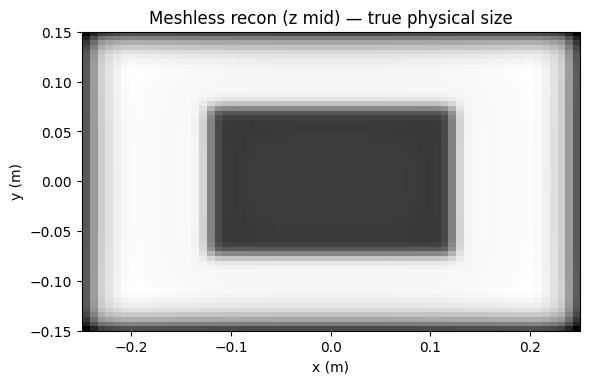

In [ ]:
# plot the middle z-slice with real-world size (y vs x)
zmin, zmax, ymin, ymax, xmin, xmax = volume_bbox_world(vg)
mid = vg.shape[0] // 2

fig, ax = plt.subplots(figsize=(6, 5))
ax.imshow(
    x_meshless_3d[mid],
    cmap='gray',
    origin='lower',
    extent=[xmin, xmax, ymin, ymax],   
)
ax.set_aspect('equal')                  # 1:1 in world units
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Meshless recon (z mid)')
plt.tight_layout(); plt.show()


Hello Sudip, here's a mini summary:

1. volume and phantom - defining this hollow cube
2. Geomemtry of source and detector - zigzag
3. Projection - simulate data via tomosipo
4. Geometry - converting world and voxel coordinate
5. (def map_view_to_zslice) Ray-plane intersection - computing each ray's hit point (meshless, no voxel grid), does not reconstruct 3d directly, just mapping 2d projections onto slices one at a time
    - the heart of it all! 
    - u compute the 3d position of each detector pixel
    - compute a ray from source to detector pixel 
    - intersect it with a plane
    - for each valid intersection, compute (y, x)
    - convert voxel coordinates  to world coords
    - splat the projection pixel value onto nearby voxels
6. flat-field correction - normalize uneven illumination
8. high pass filter - enhance in-plane edges 
9. 3d reconstruction - rebuild slice by slice
10. save as .nii (nifti) and plot middle slice (for sanity check)


Meshless = ray-plane intersections, each pixel is a weight sum of projections hitting that plane! No filtering in projection domain